### 토지피복도를 이용한 상권 영역 생성 전처리

## 패키지 로딩

In [ ]:
#  로컬용 DB 접속 정보 
user = 
pwd = 
host = 
port = 
database = 

# #psycopg2를 이용하여 PostgreSQL에 연결
import psycopg2 as pg  #PostgreSQL 연동 어댑터/드라이버
import pandas.io.sql as psql
con = pg.connect(database=database, user=user, host=host,port=port,password=pwd)

In [ ]:
# 주의 메시지 숨기기
import warnings
warnings.filterwarnings(action='ignore') 

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('float_format', '{:f}'.format)  # 숫자가 지수 형태로 표시되지 않도록
from tqdm import tqdm 
import time

In [ ]:
import geopandas as gpd
import fiona #공간데이터를 딕셔너리 형태 등으로 접근할 수 있는 라이브러리 
# from fiona.crs import from_epsg # 좌표변환 
import shapely

## 공간데이터 

### 토지피복도 폴리곤 로딩

In [ ]:
# 필요 데이터 1 불러오기
gdf_grid = gpd.read_file(r'F:/starbucks/block_se_kw_RST.shp', encoding='utf-8')

In [ ]:
# 필요 데이터 2 불러오기
with pg.connect(database=database, user=user, password=pwd, host=host, port=5432) as conn:
    sql = 'SELECT * FROM public."block_test";'
    df = psql.read_sql(sql, conn)

* 간단 그래프 확인

liv


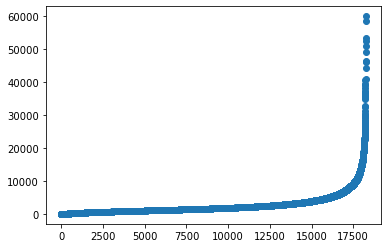

office


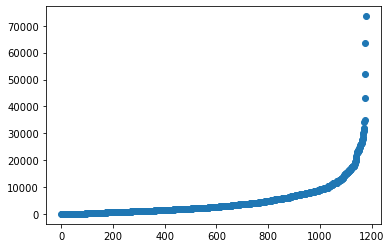

shop


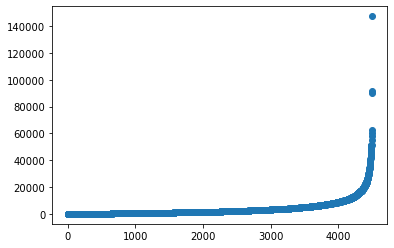

travel


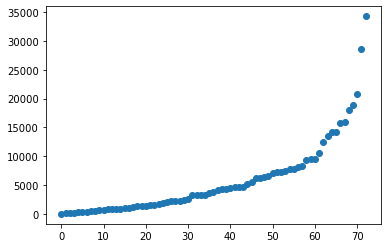

traffic


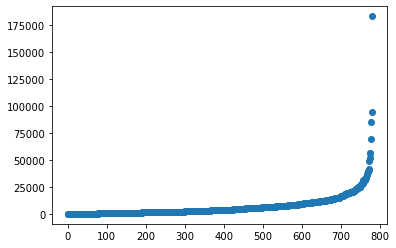

etc


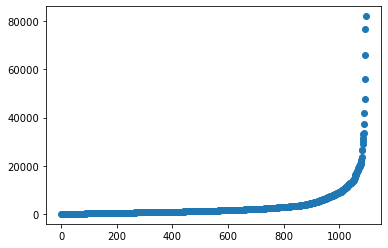

In [ ]:
# 간단한 데이터 그래프 확인
for r in df2['rank'].unique():
    print(r)
    temp = df2.loc[df['rank'] == r].sort_values(['POP_TOT'])
    temp.reset_index(inplace=True)
    plt.scatter(x=temp.loc[temp['rank'] == r].index, y=temp.loc[temp['rank'] == r]['POP_TOT'])
    plt.show()

### 필요 데이터 전처리

In [ ]:
df["geometry"] = gdf_grid['geometry']
df1 = gpd.GeoDataFrame(df)
df1["area"] = df1['geometry'].area
df1.columns

Index(['UserID', 'STD_YYYY', 'BLOCK_CD', 'SIDO_CD', 'SIDO_NM', 'SGNG_CD',
       'SGNG_NM', 'ADONG_CD', 'ADONG_NM', 'LDONG_CD', 'LDONG_NM', 'HPOP_TOT',
       'VPOP_TOT', 'WPOP_TOT', '남성_매', '여성_매', '요식_매', 'XX', 'YY', 'POP_TOT',
       'geometry', 'rank', 'area'],
      dtype='object')

In [ ]:
# 필요 컬럼 및 지역 조건 적용
df2 = df1[['BLOCK_CD', 'SIDO_NM', 'ADONG_NM', 'LDONG_NM', '요식_매', 'VPOP_TOT', 'HPOP_TOT', 'WPOP_TOT', 'POP_TOT', 'rank', 'area', 'XX', 'YY', 'geometry' ]]
df2 = df2[df2['SIDO_NM']=='서울특별시']
# len(df2.index)

In [ ]:
# null값은 0으로 치환
df2['HPOP_TOT'].fillna(0, inplace=True)
df2['VPOP_TOT'].fillna(0, inplace=True)
df2['WPOP_TOT'].fillna(0, inplace=True)
df2['POP_TOT'].fillna(0, inplace=True)
df2.isnull().sum()

BLOCK_CD    0
SIDO_NM     0
ADONG_NM    0
LDONG_NM    0
요식_매        0
POP_TOT     0
rank        0
area        0
XX          0
YY          0
geometry    0
dtype: int64

In [ ]:
# 인구 기준 이상인 데이터
df3 = df2[df2['POP_TOT']>=50000]

In [ ]:
# 인구 기준 미만인 데이터
df4 = df2[df2['POP_TOT'] < 50000]
df4.reset_index(inplace=True, drop=True)

## 로직 구동

### 필요 함수

In [ ]:
# 근접 인덱스 찾기기
def find_touches(temp, main_idx):
    # 기준 폴리곤의 인구 합
    main_POP = temp.loc[main_idx, 'POP_TOT'].sum()
    # 기준 폴리곤 병합 결과
    main_poly = temp.loc[[i for i in main_idx]].unary_union

    # 동 기준 적용시 주석 해제
#     dong_temp = temp.loc[temp['LDONG_NM'] == temp.loc[main_idx[0]]['LDONG_NM']]
#     dong_temp = temp.loc[temp['ADONG_NM'] == temp.loc[main_idx[0], 'ADONG_NM']]

    # 근접 폴리곤의 인덱스 추출
#     touch_idx = dong_temp.loc[[i for i in dong_temp.index if i not in main_idx], 'geometry'].touches(main_poly)[lambda x: x==True].index.tolist()
    touch_idx = temp.loc[[i for i in temp.index if i not in main_idx], 'geometry'].touches(main_poly)[lambda x: x==True].index.tolist()

    # 근접 폴리곤의 인덱스를 인구가 적은 순으로 정렬
#     con = temp.loc[touch_idx].sort_values(['POP_TOT'], ascending=False).index.tolist()
    con = temp.loc[touch_idx].sort_values(['POP_TOT']).index.tolist()

    return main_POP, con

In [ ]:
# 기준 유동 인구를 충족할 때까지 집계 반복
def sum_pops(temp, main_idx):
    main_POP, con = find_touches(temp, main_idx)
    
    # 합계가 50000이상이거나 섬이면 입력된 첫 인덱스를 그대로 반환
    if (main_POP >= 50000) or (len(con) <= 0):
        sum_POP = main_POP
        index_ = main_idx
        
    # 아닌 경우 50000이 될 때까지 합하고, 다 합했는데도 안되면
    else:
        for c in range(len(con)):
            sum_POP = main_POP + temp.loc[con[c], 'POP_TOT']

            if (sum_POP >= 50000) & (c <= len(con)-1):
                index_ = con[:c+1] + main_idx
                break

            elif (sum_POP < 50000) & (c >= len(con)-1):
                main_idx += con
                sum_POP, index_ = find_touches(temp, main_idx)
                # 새로 기준이 될 폴리곤 인덱스 : index_
                index_ += main_idx

            else:
                main_POP = sum_POP
            
    # 합계와 드롭(50000이상 시)시키거나
    # 이 함수에 다시 입력할(모두 합했는데도 50000이 안 되는 경우)
    # 인덱스를 반환
    return sum_POP, index_ 

In [ ]:
# 인덱스 기반 폴리곤 병합
def make_new_poly(temp, index_):
    # 각 필요컬럼 집계
    add_tmp1 = temp.loc[index_].dissolve(aggfunc='last')[['BLOCK_CD', 'SIDO_NM', 'ADONG_NM', 'LDONG_NM', 'rank']]
    add_tmp2 = temp.loc[index_].dissolve(aggfunc='sum')[['요식_매', 'POP_TOT', 'area']]
    add_tmp = pd.concat([add_tmp1, add_tmp2], axis=1)
    
    add_tmp['geometry'] = temp.loc[index_].dissolve()['geometry']
#     add_tmp['geometry'] = temp.loc[index_].unary_union

    add_tmp = gpd.GeoDataFrame(add_tmp, geometry='geometry')

    cent = add_tmp.geometry.centroid
    add_tmp['XX'], add_tmp['YY'] = cent.x, cent.y
    
    return add_tmp

### 유동 인구 기준 미만 폴리곤과 근접 폴리곤을 유동 인구가 적은 순으로 결합, 기준 이상이 되는 경우 중지

In [ ]:
result_df = pd.DataFrame()
islands_df = pd.DataFrame()
# for r in tqdm(df4['rank'].unique()):
for r in df4['rank'].unique():
    rank_islands = []
    new_poly = []
    temp = df4[df4['rank'] == r]
    start = time.time()
    print(f'rank {r} has {temp.shape[0]} polygons')
    main_idx = [temp['POP_TOT'].idxmax()]
#     num = 1
    
    while True:
        sum_POP, index_ = sum_pops(temp, main_idx)
        
        # 폴리곤 pop_tot의 합이 50000 넘은 경우
        if sum_POP >= 50000:
#             print(r + f'_{num:05d}', index_) # , sum_POP) # )
            add_tmp = make_new_poly(temp, index_)
    
            new_poly.append(add_tmp)
            temp.drop(index=index_, inplace=True)

#             print(f'{temp.shape[0]} polygons left')
            main_idx = [temp['POP_TOT'].idxmax()]
#             num += 1

        # 안 넘은 경우
        elif sum_POP < 50000:
            # 기존 폴리곤 인접 폴리곤 추출
            a, main_idx = sum_pops(temp, index_)
            
            # 섬인 경우
            if sum_POP == a:
                rank_islands.append(temp.loc[index_])
                temp.drop(index=index_, inplace=True)

#                 print(f'\n########### no more touches and {temp.shape[0]} polygons left\n')
                
                # 남은 행이 없음
                if temp.shape[0] <= 0:
                    break

                # 남은 행이 있으면 다음 기준 폴리곤 선언
                else:
                    main_idx = [temp['POP_TOT'].idxmax()]
    
            # 섬이 아니면 계속 ㄱㄱ
            else:
                pass
    
    # 새 폴리곤들 병합
    polys_temp = gpd.GeoDataFrame(pd.DataFrame()) if len(new_poly) == 0 else pd.concat(new_poly, ignore_index=True)
    print(f"rank {r} made new {polys_temp.shape[0]} polygons")
    
    # 위와 50000 넘던 애들과의 병합
    polys_temp = gpd.GeoDataFrame(pd.concat([df3[df3['rank'] == r], polys_temp.copy()], ignore_index=True))
    
    # islands_temp와 매칭
    islands_temp = gpd.GeoDataFrame(pd.concat(rank_islands, ignore_index=True))
    print(f"rank {r} left {islands_temp.shape[0]} islands")

    result_df = pd.concat([result_df, polys_temp.copy()], axis=0, ignore_index=True)
        
    islands_df = pd.concat([islands_df, islands_temp.copy()], axis=0, ignore_index=True)
    
    del polys_temp
    del islands_temp
    
    end = time.time()
    
    print(f"rank {r} took {end - start:.5f} sec\n")

df5 = gpd.GeoDataFrame(result_df, geometry='geometry')
df5.to_file('F:/starbucks/nearest_poly2.gpkg', driver='GPKG')
df6 = gpd.GeoDataFrame(islands_df, geometry='geometry')
df6.to_file('F:/starbucks/island_poly2.gpkg', driver='GPKG')

rank liv has 18236 polygons


ValueError: Length of values (2) does not match length of index (1)

### 유동인구 기준이 넘는 폴리곤들과 주변의 '섬' 결합

In [ ]:
# 근접 폴리곤 확인 후, 인덱스 추출출
def touches_sum(temp, main_idx):
    while True:
        a, con = find_touches(temp, main_idx)

        if len(con) <= 0:
            index_ = con + main_idx
            break

        else:
            main_idx += con 
        
    return index_

### 로직

In [ ]:
island_result_df = pd.DataFrame()
island_islands_df = pd.DataFrame()
for r in df6['rank'].unique():
    island_poly = []
    island_island = []
    temp = df6[df6['rank'] == r]
    
    print(f'rank {r} has {temp.shape[0]} polygons')
    main_idx = [temp['POP_TOT'].idxmax()]
    
    start = time.time()

    while True:
        a, con = find_touches(temp, main_idx)
        b = temp.loc[con + main_idx]['POP_TOT'].sum()
        
        # 기준 폴리곤과 근접 폴리곤 추출 후의 인구값이 같은 경우(근접이 없는 경우)
        if a == b:
            island_island.append(temp.loc[main_idx])
            temp.drop(index=main_idx, inplace=True)
    
        # 근접이 있는 경우
        else:
            index_ = touches_sum(temp, main_idx)
            add_tmp = make_new_poly(temp, index_)
            island_poly.append(add_tmp)
            temp.drop(index=index_, inplace=True)
        
        print(f'\n########### no more touches and {temp.shape[0]} polygons left\n')
    
        # 남은 행이 없음
        if temp.shape[0] <= 0:
            break

        # 남은 행이 있으면 다음 기준 폴리곤 선언
        else:
            main_idx = [temp['POP_TOT'].idxmax()]
 
        
    
    polys_temp = gpd.GeoDataFrame(pd.DataFrame()) if len(island_poly) == 0 else pd.concat(island_poly, ignore_index=True)
    print(f"rank {r} made new {polys_temp.shape[0]} polygons")
    islands_temp = pd.concat(island_island, ignore_index=True)
    print(f"rank {r} left {islands_temp.shape[0]} islands")
    
    island_result_df = pd.concat([island_result_df, polys_temp.copy()], axis=0, ignore_index=True)        
    island_islands_df = pd.concat([island_islands_df, islands_temp.copy()], axis=0, ignore_index=True)
    
    end = time.time()
    
    print(f"rank {r} took {end - start:.5f} sec\n")

df7 = gpd.GeoDataFrame(island_result_df, geometry='geometry')
df7.to_file('F:/starbucks/nearest_poly_island.gpkg', driver='GPKG')
df8 = gpd.GeoDataFrame(island_islands_df, geometry='geometry')
df8.to_file('F:/starbucks/island_poly_island.gpkg', driver='GPKG')

rank liv has 5017 polygons

########### no more touches and 5015 polygons left


########### no more touches and 5005 polygons left


########### no more touches and 5003 polygons left

?

########### no more touches and 5002 polygons left


########### no more touches and 5000 polygons left


########### no more touches and 4990 polygons left


########### no more touches and 4966 polygons left


########### no more touches and 4956 polygons left

?

########### no more touches and 4955 polygons left


########### no more touches and 4945 polygons left


########### no more touches and 4921 polygons left


########### no more touches and 4917 polygons left


########### no more touches and 4906 polygons left


########### no more touches and 4904 polygons left

?

########### no more touches and 4903 polygons left


########### no more touches and 4896 polygons left


########### no more touches and 4891 polygons left


########### no more touches and 4883 polygons left

?

##########


########### no more touches and 3143 polygons left


########### no more touches and 3133 polygons left


########### no more touches and 3123 polygons left


########### no more touches and 3113 polygons left


########### no more touches and 3109 polygons left


########### no more touches and 3103 polygons left


########### no more touches and 3088 polygons left

?

########### no more touches and 3087 polygons left


########### no more touches and 3074 polygons left


########### no more touches and 3066 polygons left


########### no more touches and 3063 polygons left


########### no more touches and 3041 polygons left


########### no more touches and 3017 polygons left


########### no more touches and 2980 polygons left


########### no more touches and 2974 polygons left

?

########### no more touches and 2973 polygons left

?

########### no more touches and 2972 polygons left


########### no more touches and 2960 polygons left

?

########### no more touches and 2959 


########### no more touches and 1758 polygons left


########### no more touches and 1749 polygons left

?

########### no more touches and 1748 polygons left


########### no more touches and 1728 polygons left


########### no more touches and 1717 polygons left


########### no more touches and 1711 polygons left


########### no more touches and 1700 polygons left

?

########### no more touches and 1699 polygons left


########### no more touches and 1683 polygons left


########### no more touches and 1675 polygons left


########### no more touches and 1661 polygons left

?

########### no more touches and 1660 polygons left


########### no more touches and 1649 polygons left


########### no more touches and 1646 polygons left


########### no more touches and 1614 polygons left


########### no more touches and 1601 polygons left


########### no more touches and 1598 polygons left


########### no more touches and 1593 polygons left


########### no more touches and 1583 po


########### no more touches and 754 polygons left


########### no more touches and 742 polygons left

?

########### no more touches and 741 polygons left

?

########### no more touches and 740 polygons left


########### no more touches and 737 polygons left


########### no more touches and 726 polygons left

?

########### no more touches and 725 polygons left


########### no more touches and 721 polygons left

?

########### no more touches and 720 polygons left


########### no more touches and 713 polygons left


########### no more touches and 710 polygons left

?

########### no more touches and 709 polygons left

?

########### no more touches and 708 polygons left


########### no more touches and 706 polygons left

?

########### no more touches and 705 polygons left

?

########### no more touches and 704 polygons left

?

########### no more touches and 703 polygons left

?

########### no more touches and 702 polygons left


########### no more touches and 698 polygon


########### no more touches and 318 polygons left

?

########### no more touches and 317 polygons left

?

########### no more touches and 316 polygons left

?

########### no more touches and 315 polygons left


########### no more touches and 309 polygons left


########### no more touches and 297 polygons left

?

########### no more touches and 296 polygons left

?

########### no more touches and 295 polygons left

?

########### no more touches and 294 polygons left

?

########### no more touches and 293 polygons left

?

########### no more touches and 292 polygons left

?

########### no more touches and 291 polygons left


########### no more touches and 289 polygons left


########### no more touches and 285 polygons left


########### no more touches and 283 polygons left

?

########### no more touches and 282 polygons left

?

########### no more touches and 281 polygons left

?

########### no more touches and 280 polygons left


########### no more touches and 275 pol


########### no more touches and 59 polygons left

?

########### no more touches and 58 polygons left


########### no more touches and 55 polygons left


########### no more touches and 52 polygons left

?

########### no more touches and 51 polygons left

?

########### no more touches and 50 polygons left

?

########### no more touches and 49 polygons left

?

########### no more touches and 48 polygons left

?

########### no more touches and 47 polygons left

?

########### no more touches and 46 polygons left

?

########### no more touches and 45 polygons left

?

########### no more touches and 44 polygons left

?

########### no more touches and 43 polygons left

?

########### no more touches and 42 polygons left

?

########### no more touches and 41 polygons left

?

########### no more touches and 40 polygons left

?

########### no more touches and 39 polygons left

?

########### no more touches and 38 polygons left

?

########### no more touches and 37 polygons left



########### no more touches and 365 polygons left


########### no more touches and 363 polygons left


########### no more touches and 357 polygons left


########### no more touches and 354 polygons left


########### no more touches and 343 polygons left


########### no more touches and 338 polygons left


########### no more touches and 327 polygons left


########### no more touches and 324 polygons left


########### no more touches and 320 polygons left


########### no more touches and 317 polygons left


########### no more touches and 312 polygons left


########### no more touches and 305 polygons left


########### no more touches and 291 polygons left


########### no more touches and 289 polygons left


########### no more touches and 287 polygons left


########### no more touches and 276 polygons left


########### no more touches and 267 polygons left

?

########### no more touches and 266 polygons left


########### no more touches and 264 polygons left

?

#######


########### no more touches and 1859 polygons left

?

########### no more touches and 1858 polygons left


########### no more touches and 1855 polygons left


########### no more touches and 1844 polygons left


########### no more touches and 1837 polygons left


########### no more touches and 1835 polygons left


########### no more touches and 1828 polygons left

?

########### no more touches and 1827 polygons left


########### no more touches and 1825 polygons left


########### no more touches and 1818 polygons left


########### no more touches and 1813 polygons left


########### no more touches and 1803 polygons left


########### no more touches and 1797 polygons left


########### no more touches and 1788 polygons left

?

########### no more touches and 1787 polygons left


########### no more touches and 1778 polygons left


########### no more touches and 1763 polygons left


########### no more touches and 1760 polygons left


########### no more touches and 1756 po


########### no more touches and 930 polygons left

?

########### no more touches and 929 polygons left


########### no more touches and 913 polygons left


########### no more touches and 911 polygons left


########### no more touches and 907 polygons left


########### no more touches and 899 polygons left


########### no more touches and 897 polygons left

?

########### no more touches and 896 polygons left


########### no more touches and 890 polygons left

?

########### no more touches and 889 polygons left


########### no more touches and 868 polygons left


########### no more touches and 863 polygons left


########### no more touches and 854 polygons left


########### no more touches and 849 polygons left


########### no more touches and 847 polygons left


########### no more touches and 831 polygons left


########### no more touches and 829 polygons left


########### no more touches and 825 polygons left

?

########### no more touches and 824 polygons left


###


########### no more touches and 52 polygons left


########### no more touches and 37 polygons left


########### no more touches and 33 polygons left


########### no more touches and 30 polygons left


########### no more touches and 24 polygons left

?

########### no more touches and 23 polygons left

?

########### no more touches and 22 polygons left

?

########### no more touches and 21 polygons left

?

########### no more touches and 20 polygons left


########### no more touches and 16 polygons left

?

########### no more touches and 15 polygons left

?

########### no more touches and 14 polygons left

?

########### no more touches and 13 polygons left

?

########### no more touches and 12 polygons left

?

########### no more touches and 11 polygons left

?

########### no more touches and 10 polygons left

?

########### no more touches and 9 polygons left

?

########### no more touches and 8 polygons left

?

########### no more touches and 7 polygons left

?

#####


########### no more touches and 37 polygons left


########### no more touches and 35 polygons left

?

########### no more touches and 34 polygons left


########### no more touches and 32 polygons left


########### no more touches and 27 polygons left

?

########### no more touches and 26 polygons left


########### no more touches and 24 polygons left

?

########### no more touches and 23 polygons left

?

########### no more touches and 22 polygons left

?

########### no more touches and 21 polygons left

?

########### no more touches and 20 polygons left

?

########### no more touches and 19 polygons left


########### no more touches and 17 polygons left


########### no more touches and 14 polygons left


########### no more touches and 11 polygons left

?

########### no more touches and 10 polygons left

?

########### no more touches and 9 polygons left

?

########### no more touches and 8 polygons left

?

########### no more touches and 7 polygons left

?

#########


########### no more touches and 40 polygons left

?

########### no more touches and 39 polygons left


########### no more touches and 37 polygons left

?

########### no more touches and 36 polygons left


########### no more touches and 34 polygons left

?

########### no more touches and 33 polygons left

?

########### no more touches and 32 polygons left

?

########### no more touches and 31 polygons left


########### no more touches and 29 polygons left

?

########### no more touches and 28 polygons left

?

########### no more touches and 27 polygons left


########### no more touches and 24 polygons left

?

########### no more touches and 23 polygons left

?

########### no more touches and 22 polygons left

?

########### no more touches and 21 polygons left

?

########### no more touches and 20 polygons left

?

########### no more touches and 19 polygons left

?

########### no more touches and 18 polygons left

?

########### no more touches and 17 polygons left

?



In [ ]:
# 섬 폴리곤 데이터 프레임 결합
df9 = pd.concat([df7.copy(), df8.copy()], axis=0, ignore_index=True)

### 최종 폴리곤 병합 및 최종 섬 추출

In [ ]:
final_result_df = pd.DataFrame()
final_islands_df = pd.DataFrame()

for r in df9['rank'].unique():
    final_poly = []
    final_island = []

    island_temp = df9[df9['rank'] == r]
    # 인구가 가장 적은 순으로 정렬
    polygon_temp = df5[df5['rank'] == r].sort_values(['POP_TOT'], ignore_index=True)
    pol_idx = polygon_temp.index
    
    print(f'rank {r}')
    
    start = time.time()

    for i in pol_idx:
        # 유동인구가 가장 적은 폴리곤
        temp = polygon_temp.loc[[i]]
        
        # 근접 섬의 인덱스
        touch_idx = island_temp.loc[:, 'geometry'].touches(temp['geometry'].unary_union)[lambda x: x == True].index.tolist()
        
        # 근접 폴리곤이 있는 경우
        if len(touch_idx) > 0:
            # 폴리곤 병합 후
            add_tmp = make_new_poly(pd.concat([island_temp.loc[touch_idx], temp], axis=0, ignore_index=True), [i for i in range(len(touch_idx)+1)])
            # 병합 결과에 추가
            final_poly.append(add_tmp)
            # 사용된 폴리곤 드롭
            polygon_temp.drop(index=i, inplace=True)
            # 사용된 섬 드롭
            island_temp.drop(index=touch_idx, inplace=True)
        
        # 근접이 없는 경우
        else:
            # 최종 섬에 추가
            final_island.append(island_temp.loc[touch_idx])
            # 병합 결과에 사용된 폴리곤 추가(다른 것과 병합되지 않았으므로 원본을 추가)
            final_poly.append(temp)
            # 사용된 폴리곤 드롭
            polygon_temp.drop(index=i, inplace=True)
            # 사용된 섬 드롭
            island_temp.drop(index=touch_idx, inplace=True)
    
    # 큰 폴리곤에 인접하지 못한 남은 섬
    final_island.append(island_temp)
    polys_temp = gpd.GeoDataFrame(pd.DataFrame()) if len(final_poly) == 0 else pd.concat(final_poly, ignore_index=True)
    islands_temp = pd.concat(final_island, ignore_index=True)
    
    final_result_df = pd.concat([final_result_df, polys_temp.copy()], axis=0, ignore_index=True)        
    final_islands_df = pd.concat([final_islands_df, islands_temp.copy()], axis=0, ignore_index=True)
    
    end = time.time()
    
    print(f"rank {r} took {end - start:.5f} sec\n")

df10 = gpd.GeoDataFrame(final_result_df, geometry='geometry')
df10.to_file('F:/starbucks/nearest_poly_final_real2.gpkg', driver='GPKG')
df11 = gpd.GeoDataFrame(final_islands_df, geometry='geometry')
df11.to_file('F:/starbucks/island_poly_final_real2.gpkg', driver='GPKG')

rank liv
rank liv took 9.36139 sec

rank office
rank office took 0.52177 sec

rank shop
rank shop took 2.84072 sec

rank travel
rank travel took 0.00200 sec

rank traffic
rank traffic took 0.62150 sec

rank etc
rank etc took 0.60650 sec

